In [17]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import matplotlib.patheffects as path_effects
import glob
from typing import Tuple

# 2025

In [18]:
df = pd.read_csv(r'2025\jogos_2025_formatados.csv')
df

,ano,rodada,gol_time_mandante,gol_time_visitante,mandante,visitante,data,local
0,2025,1,2,1,Cruzeiro Saf,Mirassol,29/03/2025,Mineirão - Belo Horizonte - MG
1,2025,1,2,1,Grêmio,Atlético Mineiro Saf,29/03/2025,Arena do Grêmio - Porto Alegre - RS
2,2025,1,2,0,Fortaleza Ec Saf,Fluminense,29/03/2025,Arena Castelão - Fortaleza - CE
3,2025,1,2,0,Juventude,Vitória,29/03/2025,Alfredo Jaconi - Caxias do Sul - RS
4,2025,1,0,0,São Paulo,Sport Recife,29/03/2025,Morumbi - Sao Paulo - SP
...,...,...,...,...,...,...,...,...
302,2025,31,2,0,Corinthians,Grêmio,02/11/2025,Neo Química Arena - Sao Paulo - SP
303,2025,31,2,0,Ceará,Fluminense,02/11/2025,Arena Castelão - Fortaleza - CE
304,2025,31,0,0,Internacional,Atlético Mineiro Saf,02/11/2025,Beira-Rio - Porto Alegre - RS
305,2025,31,0,2,Juventude,Palmeiras,02/11/2025,Alfredo Jaconi - Caxias do Sul - RS


In [19]:
# === CONFIGURAÇÕES ===
ARQUIVO_JOGOS = r'2025\jogos_2025_formatados.csv'
ARQUIVO_ELO = r'2025\elo_2025.csv'
ELO_INICIAL = 1000
K = 30  # fator de ajuste

# === FUNÇÃO DE ATUALIZAÇÃO DE ELO ===
def atualizar_elo(elo_mandante, elo_visitante, gols_mandante, gols_visitante, k=K):
    resultado_mandante = 1 if gols_mandante > gols_visitante else 0.5 if gols_mandante == gols_visitante else 0
    resultado_visitante = 1 - resultado_mandante

    expectativa_mandante = 1 / (1 + 10 ** ((elo_visitante - elo_mandante) / 400))
    expectativa_visitante = 1 - expectativa_mandante

    novo_elo_mandante = elo_mandante + k * (resultado_mandante - expectativa_mandante)
    novo_elo_visitante = elo_visitante + k * (resultado_visitante - expectativa_visitante)

    return novo_elo_mandante, novo_elo_visitante

# === FUNÇÃO PRINCIPAL ===
def calcular_elo_por_data():
    # Lê o arquivo de jogos
    df = pd.read_csv(ARQUIVO_JOGOS)
    df['data'] = pd.to_datetime(df['data'], errors='coerce')
    df = df.sort_values(by=['data']).reset_index(drop=True)

    # Carrega histórico existente (se houver)
    if os.path.exists(ARQUIVO_ELO):
        df_historico = pd.read_csv(ARQUIVO_ELO)
        elos = {row['time']: row['elo'] for _, row in df_historico.groupby('time').last().iterrows()}
        print(f"🔁 Histórico existente carregado ({len(elos)} times).")
    else:
        df_historico = pd.DataFrame(columns=['ano', 'rodada', 'data', 'time', 'elo'])
        elos = {}
        print("🆕 Iniciando novo cálculo de Elo.")

    # Processa cada jogo
    for idx, row in df.iterrows():
        ano, rodada = row['ano'], row['rodada']
        mandante, visitante = row['mandante'], row['visitante']
        gols_m, gols_v = row['gol_time_mandante'], row['gol_time_visitante']
        data = row['data']

        # Inicializa times novos
        if mandante not in elos:
            elos[mandante] = ELO_INICIAL
        if visitante not in elos:
            elos[visitante] = ELO_INICIAL

        # Atualiza elos
        novo_elo_m, novo_elo_v = atualizar_elo(elos[mandante], elos[visitante], gols_m, gols_v)
        elos[mandante], elos[visitante] = novo_elo_m, novo_elo_v

        # Adiciona registros
        novos_registros = pd.DataFrame([
            {'ano': ano, 'rodada': rodada, 'data': data, 'time': mandante, 'elo': round(novo_elo_m, 2)},
            {'ano': ano, 'rodada': rodada, 'data': data, 'time': visitante, 'elo': round(novo_elo_v, 2)}
        ])

        # Anexa e salva incrementalmente
        df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)
        df_historico.to_csv(ARQUIVO_ELO, index=False)

        #print(f"✅ Atualizado: {data.date()} | {mandante} x {visitante} ({gols_m}x{gols_v})")

    print(f"\n🏁 Cálculo concluído. Elo histórico salvo em '{ARQUIVO_ELO}' com {len(df_historico)} linhas.")


calcular_elo_por_data()


C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_18156\676079551.py:24: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['data'] = pd.to_datetime(df['data'], errors='coerce')
C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_18156\676079551.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)


🆕 Iniciando novo cálculo de Elo.



🏁 Cálculo concluído. Elo histórico salvo em '2025\elo_2025.csv' com 614 linhas.


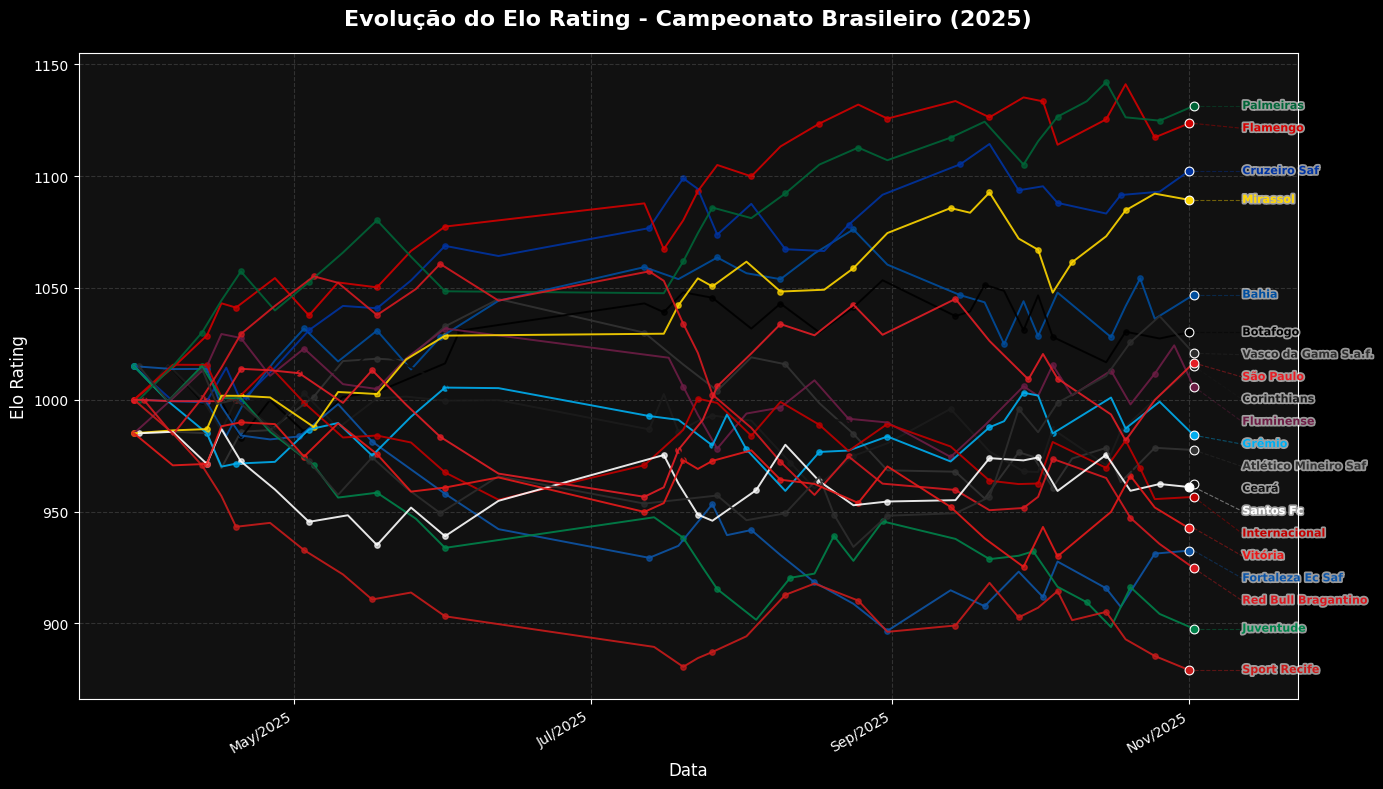

In [20]:
# Gera visualização
# === CONFIGURAÇÃO ===
ARQUIVO_ELO = r'2025\elo_2025.csv'

# === CORES FIXAS POR TIME ===
cmap_times = {"Flamengo": "#D20000",    "Palmeiras": "#006437",    "Corinthians": "#1C1C1C",    "São Paulo": "#E41E26",    "Vasco da Gama S.a.f.": "#2D2D2D",    
"Fluminense": "#6C1D45",    "Botafogo": "#000000",    "Grêmio": "#00ADEF",    "Internacional": "#C00000",    "Atlético Mineiro Saf": "#333333",    "Cruzeiro Saf": "#0033A0",    
"Bahia": "#004D9D",    "Fortaleza Ec Saf": "#0D54A5",    "Ceará": "#111111",    "Sport Recife": "#C91B1B",    "Vitória": "#E71A1A",    "Red Bull Bragantino": "#D71920",    
"Juventude": "#00824A",    "Mirassol": "#FFD700",    "Santos Fc": "#FFFFFF",    "América Mineiro": "#008000",    "Cuiabá": "#009739",    "Coritiba": "#007A33",    "Goiás": "#006B3F"}

# === LEITURA DOS DADOS ===
df = pd.read_csv(ARQUIVO_ELO)
df['data'] = pd.to_datetime(df['data'], errors='coerce')
df = df.sort_values(by=['data', 'time']).reset_index(drop=True)

# === CONFIGURAÇÃO VISUAL ===
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_facecolor("#111")

# === ORGANIZAÇÃO DOS TIMES ===
times = sorted(df['time'].unique())
cores_default = plt.cm.tab20(np.linspace(0, 1, len(times)))  # fallback

# === ÚLTIMOS PONTOS ===
ultimos = df.sort_values('data').groupby('time').last().reset_index()
ultimos = ultimos.sort_values('elo', ascending=False).reset_index(drop=True)

# === AJUSTE DE LABELS ===
espacamento_minimo = 10
posicoes_ajustadas = []
for elo in ultimos['elo']:
    if not posicoes_ajustadas:
        posicoes_ajustadas.append(elo)
    else:
        if abs(elo - posicoes_ajustadas[-1]) < espacamento_minimo:
            elo = posicoes_ajustadas[-1] - espacamento_minimo
        posicoes_ajustadas.append(elo)
ultimos['elo_ajustado'] = posicoes_ajustadas

# === PLOTAGEM ===
for i, time in enumerate(times):
    cor = cmap_times.get(time, cores_default[i])
    dados = df[df['time'] == time]
    
    # Linha
    ax.plot(dados['data'], dados['elo'], linewidth=1.4, color=cor, alpha=0.9)
    
    # Pontos intermediários
    step = max(1, len(dados)//15)
    ax.scatter(dados['data'][::step], dados['elo'][::step], color=cor, s=15, alpha=0.7)
    
    # Ponto final
    ultimo_ponto = dados.iloc[-1]
    ax.scatter(ultimo_ponto['data'], ultimo_ponto['elo'], color=cor, s=40,
               edgecolors='white', linewidth=0.8, zorder=5)

# === RÓTULOS COM CONTRASTE ===
data_final = df['data'].max() + pd.Timedelta(days=10)
for _, row in ultimos.iterrows():
    time = row['time']
    cor = cmap_times.get(time, "#AAAAAA")
    
    # Linha guia
    ax.plot(
        [df['data'].max(), data_final],
        [df[df['time'] == time]['elo'].iloc[-1], row['elo_ajustado']],
        color=cor, alpha=0.4, linewidth=0.8, linestyle="--"
    )
    
    # Texto com contraste (glow branco fino)
    txt = ax.text(
        data_final,
        row['elo_ajustado'],
        time,
        fontsize=8,
        color=cor,
        va='center',
        weight='bold',
        zorder=10
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2.5, foreground='white', alpha=0.6),
        path_effects.Normal()
    ])

# === FORMATAÇÃO ===
plt.title('Evolução do Elo Rating - Campeonato Brasileiro (2025)',
          fontsize=16, weight='bold', pad=20, color='white')
plt.xlabel('Data', fontsize=12, color='white')
plt.ylabel('Elo Rating', fontsize=12, color='white')
plt.grid(True, linestyle='--', alpha=0.3, color='gray')
ax.tick_params(colors='white', which='both')

# Eixo temporal
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [21]:
# === CONFIGURAÇÕES ===
ARQUIVO_ELO = r'2025\elo_2025.csv'
THRESHOLD_EMPATE = 5  # quanto mais alto, mais empates são previstos

# === FUNÇÕES ===
def carregar_elos():
    """Carrega o último Elo conhecido de cada time."""
    df = pd.read_csv(ARQUIVO_ELO)
    df = df.sort_values(by=['data']).dropna(subset=['time', 'elo'])
    ultimos = df.groupby('time')['elo'].last().to_dict()
    return ultimos

def probabilidade_vitoria(elo_a, elo_b):
    """Calcula a probabilidade de vitória de A sobre B (modelo Elo clássico)."""
    return 1 / (1 + 10 ** ((elo_b - elo_a) / 400))

def prever_resultado(time_a, time_b, elos):
    """Prediz o resultado mais provável entre dois times."""
    if time_a not in elos or time_b not in elos:
        return f"❌ Um dos times ({time_a}, {time_b}) não tem Elo registrado."

    elo_a, elo_b = elos[time_a], elos[time_b]
    p_a = probabilidade_vitoria(elo_a, elo_b)
    p_b = 1 - p_a

    # Probabilidade empírica de empate (quanto mais próximos, maior chance)
    diff = abs(p_a - 0.5)
    p_empate = max(0, (1 - diff * 10)) * THRESHOLD_EMPATE

    # Normaliza probabilidades
    total = p_a + p_b + p_empate
    p_a, p_b, p_empate = p_a / total, p_b / total, p_empate / total

    # Escolha final
    if max(p_a, p_b, p_empate) == p_empate:
        resultado = "Empate"
    elif p_a > p_b:
        resultado = time_a
    else:
        resultado = time_b

    return {
        "time_A": time_a,
        "Elo_A": round(elo_a, 2),
        "time_B": time_b,
        "Elo_B": round(elo_b, 2),
        "P(A)": round(p_a, 3),
        "P(Empate)": round(p_empate, 3),
        "P(B)": round(p_b, 3),
        "Previsão": resultado
    }



In [22]:
# Encontra os jogos ainda não disputados na temporada

# === CONFIGURAÇÕES ===
ARQUIVO_JOGOS = "2025/jogos_2025_formatados.csv"
ANO = 2025  # ano de interesse

# === LEITURA DOS DADOS ===
df = pd.read_csv(ARQUIVO_JOGOS)
df.columns = [c.strip().lower() for c in df.columns]
df = df[df["ano"] == ANO].copy()

# Normaliza nomes de times
df["mandante"] = df["mandante"].astype(str).str.strip()
df["visitante"] = df["visitante"].astype(str).str.strip()

# === CRIA CHAVE DE CONFRONTO ===
# Cada confronto é definido pelo conjunto (mandante, visitante), ignorando ordem
df["confronto"] = df.apply(lambda row: "_".join(sorted([row["mandante"], row["visitante"]])), axis=1).astype(str)

# === CONTA QUANTOS JOGOS CADA CONFRONTO TEVE ===
contagem = df["confronto"].value_counts().reset_index()
contagem.columns = ["confronto", "ocorrencias"]

# === IDENTIFICA OS CONFRONTOS INCOMPLETOS (MENOS DE 2 JOGOS) ===
faltando = contagem[contagem["ocorrencias"] < 2]

# === MONTA LISTA DE JOGOS FALTANTES ===
faltantes_lista = []

for confronto in faltando["confronto"]:
    time1, time2 = confronto.split("_")
    subset = df[df["confronto"] == confronto]
    mandantes_existentes = set(subset["mandante"])

    # Define quem ainda precisa ser mandante
    if time1 not in mandantes_existentes:
        faltantes_lista.append((time1, time2))
    elif time2 not in mandantes_existentes:
        faltantes_lista.append((time2, time1))
    else:
        # Caso raro: ambos já foram mandantes (erro ou duplicado)
        faltantes_lista.append(("?", "?"))

# === RESULTADO FINAL ===
df_faltantes = pd.DataFrame(faltantes_lista, columns=["Mandante", "Visitante"]).dropna()
df_faltantes = df_faltantes[df_faltantes["Mandante"] != "?"]
df_faltantes = df_faltantes.sort_values(by=["Mandante", "Visitante"]).reset_index(drop=True)

print("\n⚽ JOGOS FALTANTES DO BRASILEIRÃO 2025\n")

# === SALVA RESULTADO ===
df_faltantes



⚽ JOGOS FALTANTES DO BRASILEIRÃO 2025



,Mandante,Visitante
0,Atlético Mineiro Saf,Bahia
1,Atlético Mineiro Saf,Flamengo
2,Atlético Mineiro Saf,Palmeiras
3,Atlético Mineiro Saf,Vasco da Gama S.a.f.
4,Bahia,Fortaleza Ec Saf
...,...,...
64,Vasco da Gama S.a.f.,Mirassol
65,Vitória,Botafogo
66,Vitória,Internacional
67,Vitória,Mirassol


In [23]:
# Previsões para jogos não disputados
 
elos = carregar_elos()
resultados = []
for time_a, time_b in zip(df_faltantes.Mandante.to_list(), df_faltantes.Visitante.to_list()):
    previsao = prever_resultado(time_a, time_b, elos)
    print("\n📊 Resultado da previsão:")
    for k, v in previsao.items():
        print(f"{k}: {v}")
    resultados.append([time_a,time_b,v])
    print("\n" + "-"*50 + "\n")



📊 Resultado da previsão:
time_A: Atlético Mineiro Saf
Elo_A: 977.51
time_B: Bahia
Elo_B: 1046.94
P(A): 0.375
P(Empate): 0.065
P(B): 0.56
Previsão: Bahia

--------------------------------------------------


📊 Resultado da previsão:
time_A: Atlético Mineiro Saf
Elo_A: 977.51
time_B: Flamengo
Elo_B: 1123.55
P(A): 0.301
P(Empate): 0.0
P(B): 0.699
Previsão: Flamengo

--------------------------------------------------


📊 Resultado da previsão:
time_A: Atlético Mineiro Saf
Elo_A: 977.51
time_B: Palmeiras
Elo_B: 1131.37
P(A): 0.292
P(Empate): 0.0
P(B): 0.708
Previsão: Palmeiras

--------------------------------------------------


📊 Resultado da previsão:
time_A: Atlético Mineiro Saf
Elo_A: 977.51
time_B: Vasco da Gama S.a.f.
Elo_B: 1020.77
P(A): 0.151
P(Empate): 0.656
P(B): 0.194
Previsão: Empate

--------------------------------------------------


📊 Resultado da previsão:
time_A: Bahia
Elo_A: 1046.94
time_B: Fortaleza Ec Saf
Elo_B: 932.52
P(A): 0.659
P(Empate): 0.0
P(B): 0.341
Previsão: 

In [24]:
# Campeonato até o momento

# === CONFIGURAÇÕES ===
ARQUIVO_JOGOS = r"2025\jogos_2025_formatados.csv"
ANO = 2025  # Filtrar apenas jogos de 2025

# === LEITURA DOS DADOS ===
df = pd.read_csv(ARQUIVO_JOGOS)

# Garante nomes de colunas consistentes
df.columns = [c.strip().lower() for c in df.columns]
df = df[df["ano"] == ANO]

# === INICIALIZAÇÃO ===
times = set(df["mandante"]) | set(df["visitante"])
tabela = pd.DataFrame({
    "Time": list(times),
    "P": 0,     # Pontos
    "J": 0,     # Jogos
    "V": 0,     # Vitórias
    "E": 0,     # Empates
    "D": 0,     # Derrotas
    "GP": 0,    # Gols Pró
    "GC": 0,    # Gols Contra
    "SG": 0,    # Saldo
})

tabela.set_index("Time", inplace=True)

# === PROCESSAMENTO DOS JOGOS ===
for _, row in df.iterrows():
    mandante = row["mandante"]
    visitante = row["visitante"]
    gm = int(row["gol_time_mandante"])
    gv = int(row["gol_time_visitante"])

    # Atualiza jogos
    tabela.loc[mandante, "J"] += 1
    tabela.loc[visitante, "J"] += 1

    # Gols
    tabela.loc[mandante, "GP"] += gm
    tabela.loc[mandante, "GC"] += gv
    tabela.loc[visitante, "GP"] += gv
    tabela.loc[visitante, "GC"] += gm

    # Resultado
    if gm > gv:  # vitória mandante
        tabela.loc[mandante, "V"] += 1
        tabela.loc[visitante, "D"] += 1
        tabela.loc[mandante, "P"] += 3
    elif gm < gv:  # vitória visitante
        tabela.loc[visitante, "V"] += 1
        tabela.loc[mandante, "D"] += 1
        tabela.loc[visitante, "P"] += 3
    else:  # empate
        tabela.loc[mandante, "E"] += 1
        tabela.loc[visitante, "E"] += 1
        tabela.loc[mandante, "P"] += 1
        tabela.loc[visitante, "P"] += 1

# === CALCULA SALDO ===
tabela["SG"] = tabela["GP"] - tabela["GC"]

# === ORDENAÇÃO (CRITÉRIOS OFICIAIS) ===
tabela = tabela.sort_values(
    by=["P", "V", "SG", "GP", "GC", "Time"],
    ascending=[False, False, False, False, True, True]
).reset_index()

# === FORMATAÇÃO FINAL ===
tabela["Posição"] = range(1, len(tabela) + 1)
tabela = tabela[
    ["Posição", "Time", "P", "J", "V", "E", "D", "GP", "GC", "SG"]
]

# === RESULTADO ===
print("\n🏆 CLASSIFICAÇÃO DO BRASILEIRÃO 2025\n")
display(tabela.set_index('Posição'))

# === OPCIONAL: salva em CSV ===
tabela.to_csv("classificacao_brasileirao_2025.csv", index=False)
print("\n✅ Arquivo salvo: classificacao_brasileirao_2025.csv")



🏆 CLASSIFICAÇÃO DO BRASILEIRÃO 2025



,Time,P,J,V,E,D,GP,GC,SG
Posição,,,,,,,,,
1,Palmeiras,65,30,20,5,5,55,26,29
2,Flamengo,64,30,19,7,4,59,16,43
3,Cruzeiro Saf,60,31,17,9,5,45,22,23
4,Mirassol,56,31,15,11,5,52,31,21
5,Bahia,52,31,15,7,9,42,35,7
6,Botafogo,48,31,13,9,9,41,28,13
7,Fluminense,47,31,14,5,12,37,37,0
8,São Paulo,44,31,12,8,11,35,33,2
9,Vasco da Gama S.a.f.,42,31,12,6,13,49,43,6



✅ Arquivo salvo: classificacao_brasileirao_2025.csv


In [25]:
# Campeonato após as previsões

# === 1️⃣ Lê a tabela atual ===
tabela = pd.read_csv("classificacao_brasileirao_2025.csv")

# === 2️⃣ Lista de previsões ===
previsoes = resultados

# === 3️⃣ Atualiza estatísticas conforme previsões ===
tabela.set_index("Time", inplace=True)

for mandante, visitante, resultado in previsoes:
    if resultado == "Empate":
        gm, gv = 0, 0
        tabela.loc[mandante, "E"] += 1
        tabela.loc[visitante, "E"] += 1
        tabela.loc[mandante, "P"] += 1
        tabela.loc[visitante, "P"] += 1
    elif resultado == mandante:  # vitória do mandante
        gm, gv = 1, 0
        tabela.loc[mandante, "V"] += 1
        tabela.loc[visitante, "D"] += 1
        tabela.loc[mandante, "P"] += 3
    else:  # vitória do visitante
        gm, gv = 0, 1
        tabela.loc[visitante, "V"] += 1
        tabela.loc[mandante, "D"] += 1
        tabela.loc[visitante, "P"] += 3

    # Atualiza jogos e gols
    tabela.loc[mandante, "J"] += 1
    tabela.loc[visitante, "J"] += 1
    tabela.loc[mandante, "GP"] += gm
    tabela.loc[visitante, "GP"] += gv
    tabela.loc[mandante, "GC"] += gv
    tabela.loc[visitante, "GC"] += gm

# === 4️⃣ Recalcula saldo de gols ===
tabela["SG"] = tabela["GP"] - tabela["GC"]

# === 5️⃣ Reordena conforme critérios oficiais ===
tabela = tabela.sort_values(
    by=["P", "V", "SG", "GP", "GC", "Time"],
    ascending=[False, False, False, False, True, True]
).reset_index()

# === 6️⃣ Adiciona posição ===
tabela["Posição"] = range(1, len(tabela) + 1)
tabela = tabela[["Posição", "Time", "P", "J", "V", "E", "D", "GP", "GC", "SG"]]

# === 7️⃣ Resultado final ===
print("\n🏆 CLASSIFICAÇÃO PROJETADA DO BRASILEIRÃO 2025 (com previsões)\n")
display(tabela.set_index('Posição'))

# === 8️⃣ (Opcional) salva nova tabela ===
tabela.to_csv("classificacao_brasileirao_2025_projetada.csv", index=False)
print("\n✅ Nova classificação salva: classificacao_brasileirao_2025_projetada.csv")



🏆 CLASSIFICAÇÃO PROJETADA DO BRASILEIRÃO 2025 (com previsões)



,Time,P,J,V,E,D,GP,GC,SG
Posição,,,,,,,,,
1,Flamengo,86,38,26,8,4,66,16,50
2,Palmeiras,81,36,25,6,5,60,26,34
3,Cruzeiro Saf,81,38,24,9,5,52,22,30
4,Mirassol,73,38,20,13,5,57,31,26
5,Bahia,69,38,20,9,9,47,35,12
6,Botafogo,60,38,16,12,10,44,29,15
7,São Paulo,56,38,15,11,12,38,34,4
8,Corinthians,54,38,14,12,12,37,36,1
9,Vasco da Gama S.a.f.,52,38,14,10,14,51,44,7



✅ Nova classificação salva: classificacao_brasileirao_2025_projetada.csv


# O quão precisa é essa análise?

In [31]:
# === CONFIGURAÇÕES ===
ARQUIVO_JOGOS = "jogos_todos_formatados.csv"
ELO_INICIAL = 1000
K = 30  # fator de ajuste

# === FUNÇÃO DE ATUALIZAÇÃO DE ELO ===
def atualizar_elo(elo_mandante, elo_visitante, gols_mandante, gols_visitante, k=K):
    resultado_mandante = 1 if gols_mandante > gols_visitante else 0.5 if gols_mandante == gols_visitante else 0
    resultado_visitante = 1 - resultado_mandante

    expectativa_mandante = 1 / (1 + 10 ** ((elo_visitante - elo_mandante) / 400))
    expectativa_visitante = 1 - expectativa_mandante

    novo_elo_mandante = elo_mandante + k * (resultado_mandante - expectativa_mandante)
    novo_elo_visitante = elo_visitante + k * (resultado_visitante - expectativa_visitante)

    return novo_elo_mandante, novo_elo_visitante


# === FUNÇÃO DE PREVISÃO DE RESULTADOS ===
def prever_resultado(elo_m, elo_v):
    """Retorna previsão de resultado com base na diferença de Elo."""
    prob_mandante = 1 / (1 + 10 ** ((elo_v - elo_m) / 400))
    if abs(elo_m - elo_v) < 20:
        return "Empate"
    elif prob_mandante > 0.5:
        return "Mandante"
    else:
        return "Visitante"


# === LOOP PRINCIPAL POR ANO ===
df_todos = pd.read_csv(ARQUIVO_JOGOS)
df_todos["data"] = pd.to_datetime(df_todos["data"], errors="coerce")

for ano in sorted(df_todos["ano"].unique()):
    print(f"\n🏆 Processando ano {ano}...")

    df = df_todos[df_todos["ano"] == ano].copy()
    df = df.sort_values(["rodada", "data"]).reset_index(drop=True)

    elos = {}
    df_historico = pd.DataFrame(columns=["ano", "rodada", "data", "time", "elo"])
    previsoes = []
    erros = []

    # === CRIA ARQUIVO DE PREVISÃO COM RODADA 1 REAL ===
    primeira_rodada = df[df["rodada"] == 1].copy()
    primeira_rodada_prev = primeira_rodada.rename(columns={
        "gol_time_mandante": "gol_prev_mandante",
        "gol_time_visitante": "gol_prev_visitante"
    })
    primeira_rodada_prev["previsao"] = "Real"

    nome_prev = f"previsao_{ano}.csv"
    primeira_rodada_prev[[
        "ano", "rodada", "mandante", "visitante",
        "gol_prev_mandante", "gol_prev_visitante", "previsao"
    ]].to_csv(nome_prev, index=False)

    print(f"✅ Rodada 1 real adicionada em {nome_prev}")
    
    # === LOOP DE RODADAS ===
    for rodada in sorted(df["rodada"].unique()):
        df_rodada = df[df["rodada"] == rodada]

        # === SE NÃO FOR A PRIMEIRA RODADA → FAZ PREVISÃO ===
        if rodada > 1:
            previsoes_rodada = []
            for _, jogo in df_rodada.iterrows():
                mandante, visitante = jogo["mandante"], jogo["visitante"]
                elo_m = elos.get(mandante, ELO_INICIAL)
                elo_v = elos.get(visitante, ELO_INICIAL)
                previsao = prever_resultado(elo_m, elo_v)

                # converte previsão em gols (1x0, 0x1, 0x0)
                if previsao == "Mandante":
                    g_m, g_v = 1, 0
                elif previsao == "Visitante":
                    g_m, g_v = 0, 1
                else:
                    g_m, g_v = 0, 0

                previsoes_rodada.append({
                    "ano": ano,
                    "rodada": rodada,
                    "mandante": mandante,
                    "visitante": visitante,
                    "gol_prev_mandante": g_m,
                    "gol_prev_visitante": g_v,
                    "previsao": previsao
                })

            # salva previsões
            df_prev = pd.DataFrame(previsoes_rodada)
            nome_prev = f"previsao_{ano}.csv"
            if os.path.exists(nome_prev):
                df_prev_total = pd.read_csv(nome_prev)
                df_prev_total = pd.concat([df_prev_total, df_prev], ignore_index=True)
            else:
                df_prev_total = df_prev
            df_prev_total.to_csv(nome_prev, index=False)

            previsoes.append(df_prev)

            # === CALCULA ERROS DE PREVISÃO ===
            df_real = df_rodada.copy()
            df_erro = df_prev.merge(df_real, on=["ano", "rodada", "mandante", "visitante"], suffixes=("_prev", "_real"))

            def pontos(gm, gv):
                return 3 if gm > gv else 1 if gm == gv else 0

            df_erro["pontos_prev_mandante"] = df_erro.apply(lambda r: pontos(r.gol_prev_mandante, r.gol_prev_visitante), axis=1)
            df_erro["pontos_prev_visitante"] = df_erro.apply(lambda r: pontos(r.gol_prev_visitante, r.gol_prev_mandante), axis=1)
            df_erro["pontos_real_mandante"] = df_erro.apply(lambda r: pontos(r.gol_time_mandante, r.gol_time_visitante), axis=1)
            df_erro["pontos_real_visitante"] = df_erro.apply(lambda r: pontos(r.gol_time_visitante, r.gol_time_mandante), axis=1)
            df_erro["erro_mandante"] = df_erro["pontos_prev_mandante"] - df_erro["pontos_real_mandante"]
            df_erro["erro_visitante"] = df_erro["pontos_prev_visitante"] - df_erro["pontos_real_visitante"]

            nome_erro = f"erros_{ano}.csv"
            if os.path.exists(nome_erro):
                df_erro_total = pd.read_csv(nome_erro)
                df_erro_total = pd.concat([df_erro_total, df_erro], ignore_index=True)
            else:
                df_erro_total = df_erro
            df_erro_total.to_csv(nome_erro, index=False)

            erros.append(df_erro)

        # === ATUALIZA OS ELOS BASEADOS NOS RESULTADOS REAIS ===
        for _, jogo in df_rodada.iterrows():
            mandante, visitante = jogo["mandante"], jogo["visitante"]
            gm, gv = jogo["gol_time_mandante"], jogo["gol_time_visitante"]
            data = jogo["data"]

            if mandante not in elos:
                elos[mandante] = ELO_INICIAL
            if visitante not in elos:
                elos[visitante] = ELO_INICIAL

            novo_elo_m, novo_elo_v = atualizar_elo(elos[mandante], elos[visitante], gm, gv)
            elos[mandante], elos[visitante] = novo_elo_m, novo_elo_v

            novos_registros = pd.DataFrame([
                {"ano": ano, "rodada": rodada, "data": data, "time": mandante, "elo": round(novo_elo_m, 2)},
                {"ano": ano, "rodada": rodada, "data": data, "time": visitante, "elo": round(novo_elo_v, 2)},
            ])

            df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)

        # salva histórico de Elo incrementalmente
        df_historico.to_csv(f"elo_{ano}.csv", index=False)

    print(f"✅ Ano {ano} processado: {len(df_historico)} registros de Elo, {len(previsoes)} rodadas previstas.")


C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_18156\1393155274.py:34: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_todos["data"] = pd.to_datetime(df_todos["data"], errors="coerce")
C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_18156\1393155274.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)



🏆 Processando ano 2018...
✅ Rodada 1 real adicionada em previsao_2018.csv
✅ Ano 2018 processado: 760 registros de Elo, 37 rodadas previstas.

🏆 Processando ano 2019...
✅ Rodada 1 real adicionada em previsao_2019.csv


C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_18156\1393155274.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)


✅ Ano 2019 processado: 760 registros de Elo, 37 rodadas previstas.

🏆 Processando ano 2020...
✅ Rodada 1 real adicionada em previsao_2020.csv


C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_18156\1393155274.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)


✅ Ano 2020 processado: 760 registros de Elo, 37 rodadas previstas.

🏆 Processando ano 2021...
✅ Rodada 1 real adicionada em previsao_2021.csv


C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_18156\1393155274.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)


✅ Ano 2021 processado: 760 registros de Elo, 37 rodadas previstas.

🏆 Processando ano 2022...
✅ Rodada 1 real adicionada em previsao_2022.csv


C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_18156\1393155274.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)


✅ Ano 2022 processado: 760 registros de Elo, 37 rodadas previstas.

🏆 Processando ano 2023...
✅ Rodada 1 real adicionada em previsao_2023.csv


C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_18156\1393155274.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)


✅ Ano 2023 processado: 760 registros de Elo, 37 rodadas previstas.

🏆 Processando ano 2024...
✅ Rodada 1 real adicionada em previsao_2024.csv


C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_18156\1393155274.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)


✅ Ano 2024 processado: 760 registros de Elo, 37 rodadas previstas.

🏆 Processando ano 2025...
✅ Rodada 1 real adicionada em previsao_2025.csv


C:\Users\Alex Moulin\AppData\Local\Temp\ipykernel_18156\1393155274.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_historico = pd.concat([df_historico, novos_registros], ignore_index=True)


✅ Ano 2025 processado: 614 registros de Elo, 30 rodadas previstas.


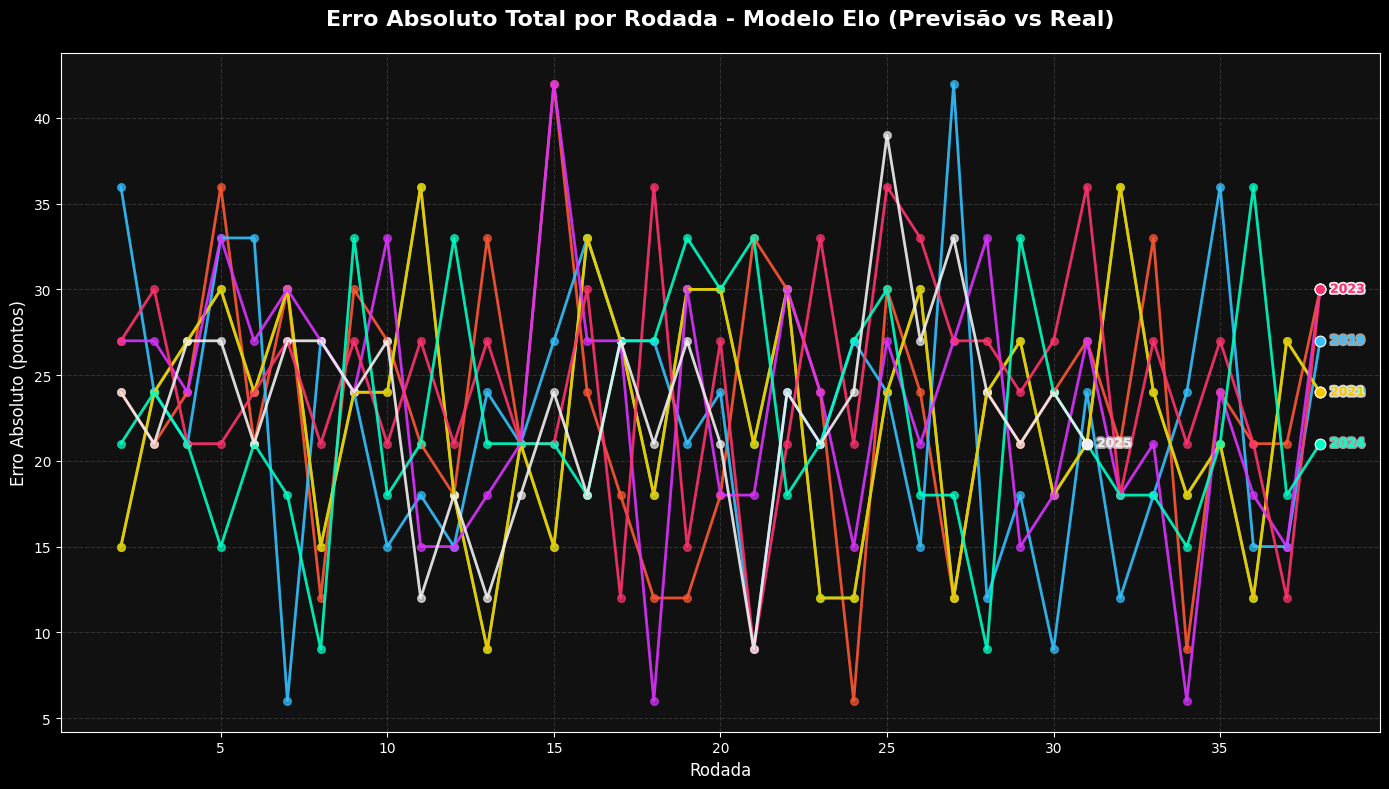

In [32]:
# === CORES PADRÃO PARA OS ANOS ===
cores_anos = {
    2018: "#FF5733",  # laranja
    2019: "#33C1FF",  # azul claro
    2020: "#33FF57",  # verde
    2021: "#FFC300",  # amarelo
    2022: "#DA33FF",  # roxo
    2023: "#FF336E",  # magenta
    2024: "#00FFC3",  # ciano
    2025: "#F0F0F0",  # branco suave
}

# === BUSCA TODOS OS ARQUIVOS DE ERROS ===
arquivos_erros = sorted(glob.glob("erros_*.csv"))
dados = []

for arquivo in arquivos_erros:
    ano = int(arquivo.split("_")[1].split(".")[0])
    df = pd.read_csv(arquivo)
    
    # calcula erro absoluto total (sem média)
    df["erro_abs_total"] = df["erro_mandante"].abs() + df["erro_visitante"].abs()
    erro_por_rodada = df.groupby("rodada")["erro_abs_total"].sum().reset_index()
    erro_por_rodada["ano"] = ano
    dados.append(erro_por_rodada)

# === COMBINA TUDO ===
df_todos = pd.concat(dados, ignore_index=True)
df_todos = df_todos.sort_values(["ano", "rodada"])

# === CONFIGURAÇÃO VISUAL ===
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_facecolor("#111")

# === PLOTAGEM ===
anos = sorted(df_todos["ano"].unique())

for ano in anos:
    cor = cores_anos.get(ano, plt.cm.tab20(np.random.rand()))
    dados_ano = df_todos[df_todos["ano"] == ano]
    
    # curva principal
    ax.plot(dados_ano["rodada"], dados_ano["erro_abs_total"], color=cor, linewidth=2, alpha=0.9)
    
    # pontos intermediários
    ax.scatter(dados_ano["rodada"], dados_ano["erro_abs_total"], color=cor, s=30, alpha=0.7)
    
    # ponto final
    ultimo = dados_ano.iloc[-1]
    ax.scatter(ultimo["rodada"], ultimo["erro_abs_total"], color=cor, s=60, edgecolors="white", linewidth=0.8, zorder=5)
    
    # rótulo com contorno branco para contraste
    txt = ax.text(
        ultimo["rodada"] + 0.3,
        ultimo["erro_abs_total"],
        str(ano),
        fontsize=9,
        color=cor,
        va="center",
        weight="bold"
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2.5, foreground="white", alpha=0.6),
        path_effects.Normal()
    ])

# === FORMATAÇÃO ===
plt.title("Erro Absoluto Total por Rodada - Modelo Elo (Previsão vs Real)",
          fontsize=16, weight="bold", pad=20, color="white")
plt.xlabel("Rodada", fontsize=12, color="white")
plt.ylabel("Erro Absoluto (pontos)", fontsize=12, color="white")

plt.grid(True, linestyle="--", alpha=0.3, color="gray")
ax.tick_params(colors="white", which="both")

# ajusta limites e layout
plt.tight_layout()
plt.show()


In [34]:
# ======================================================
# 🔧 CONFIGURAÇÕES
# ======================================================
ARQUIVO_JOGOS = "jogos_todos_formatados.csv"
PASTA_SAIDA = "classificacoes_anuais"
os.makedirs(PASTA_SAIDA, exist_ok=True)


# ======================================================
# 🧮 FUNÇÃO DE CLASSIFICAÇÃO
# ======================================================
def calcular_classificacao(df: pd.DataFrame, tipo: str, ano: int) -> pd.DataFrame:
    """
    Calcula a tabela de classificação de um DataFrame de jogos,
    garantindo que os acumuladores de pontos e gols estejam corretos.
    """
    clubes = set(df["mandante"]).union(df["visitante"])
    tabela = pd.DataFrame({
        "time": list(clubes),
        "pontos": 0,
        "vitorias": 0,
        "empates": 0,
        "derrotas": 0,
        "gols_pro": 0,
        "gols_contra": 0
    }).set_index("time")

    for _, jogo in df.iterrows():
        mandante, visitante = jogo["mandante"], jogo["visitante"]
        gm, gv = int(jogo["gol_time_mandante"]), int(jogo["gol_time_visitante"])

        # gols
        tabela.at[mandante, "gols_pro"] += gm
        tabela.at[mandante, "gols_contra"] += gv
        tabela.at[visitante, "gols_pro"] += gv
        tabela.at[visitante, "gols_contra"] += gm

        # resultado
        if gm > gv:
            tabela.at[mandante, "pontos"] += 3
            tabela.at[mandante, "vitorias"] += 1
            tabela.at[visitante, "derrotas"] += 1
        elif gv > gm:
            tabela.at[visitante, "pontos"] += 3
            tabela.at[visitante, "vitorias"] += 1
            tabela.at[mandante, "derrotas"] += 1
        else:
            tabela.at[mandante, "pontos"] += 1
            tabela.at[visitante, "pontos"] += 1
            tabela.at[mandante, "empates"] += 1
            tabela.at[visitante, "empates"] += 1

    tabela["saldo"] = tabela["gols_pro"] - tabela["gols_contra"]
    tabela = tabela.reset_index()
    tabela = tabela.sort_values(
        by=["pontos", "vitorias", "saldo", "gols_pro"],
        ascending=False
    ).reset_index(drop=True)

    tabela.insert(0, "ano", ano)
    tabela.insert(1, "tipo", tipo)
    tabela.insert(2, "posicao", range(1, len(tabela) + 1))
    return tabela


# ======================================================
# ⚙️ FUNÇÃO PRINCIPAL
# ======================================================
def gerar_tabelas_ano(ano: int):
    """
    Gera e salva as tabelas REAL e PREVISTA para o ano informado.
    - Lê `jogos_todos_formatados.csv`
    - Lê `previsao_{ano}.csv`
    - Salva `classificacao_real_{ano}.csv` e `classificacao_prevista_{ano}.csv`
    """
    print(f"📊 Gerando tabelas para o ano {ano}...")

    # === LER DADOS ===
    df_jogos = pd.read_csv(ARQUIVO_JOGOS)
    df_prev = pd.read_csv(f"previsao_{ano}.csv")

    # Normaliza nomes de colunas de gols (caso venham como 'gol_prev_...')
    df_prev = df_prev.rename(columns={
        "gol_prev_mandante": "gol_time_mandante",
        "gol_prev_visitante": "gol_time_visitante"
    })

    # === FILTRA POR ANO ===
    df_real_ano = df_jogos[df_jogos["ano"] == ano].copy()
    df_prev_ano = df_prev[df_prev["ano"] == ano].copy() if "ano" in df_prev.columns else df_prev.copy()

    # === CALCULA TABELAS ===
    tabela_real = calcular_classificacao(df_real_ano, "Real", ano)
    tabela_prev = calcular_classificacao(df_prev_ano, "Previsão", ano)

    # === SALVA RESULTADOS ===
    arq_real = os.path.join(PASTA_SAIDA, f"classificacao_real_{ano}.csv")
    arq_prev = os.path.join(PASTA_SAIDA, f"classificacao_prevista_{ano}.csv")

    tabela_real.to_csv(arq_real, index=False)
    tabela_prev.to_csv(arq_prev, index=False)

    print(f"✅ Salvo: {arq_real} | {arq_prev}")
    return tabela_real, tabela_prev

# ======================================================
# 🚀 EXEMPLO DE USO
# ======================================================
if __name__ == "__main__":
    # Gera as tabelas do ano desejado
    for ano_desejado in range(2018,2025):
        tabela_real, tabela_prev = gerar_tabelas_ano(ano_desejado)

        print(f"\n📋 {ano_desejado} Classificação REAL:")
        display(tabela_real.set_index('posicao'))

        print(f"\n📋 {ano_desejado} Classificação PREVISTA:")
        display(tabela_prev.set_index('posicao'))

📊 Gerando tabelas para o ano 2018...
✅ Salvo: classificacoes_anuais\classificacao_real_2018.csv | classificacoes_anuais\classificacao_prevista_2018.csv

📋 2018 Classificação REAL:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2018,Real,Palmeiras,80,23,11,4,64,26,38
2,2018,Real,Flamengo,72,21,9,8,59,29,30
3,2018,Real,Internacional,69,19,12,7,51,29,22
4,2018,Real,Grêmio,66,18,12,8,48,27,21
5,2018,Real,São Paulo,63,16,15,7,46,34,12
6,2018,Real,Atlético Mineiro,59,17,8,13,56,43,13
7,2018,Real,Athletico Paranaense,57,16,9,13,54,37,17
8,2018,Real,Cruzeiro,53,14,11,13,34,34,0
9,2018,Real,Botafogo,51,13,12,13,38,46,-8



📋 2018 Classificação PREVISTA:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2018,Previsão,Flamengo,96,30,6,2,32,4,28
2,2018,Previsão,Internacional,95,30,5,3,31,3,28
3,2018,Previsão,São Paulo,91,28,7,3,28,3,25
4,2018,Previsão,Palmeiras,90,28,6,4,29,5,24
5,2018,Previsão,Grêmio,86,26,8,4,26,4,22
6,2018,Previsão,Atlético Mineiro,69,19,12,7,20,8,12
7,2018,Previsão,Cruzeiro,56,16,8,14,16,14,2
8,2018,Previsão,Corinthians,54,15,9,14,16,15,1
9,2018,Previsão,Bahia,44,11,11,16,11,17,-6


📊 Gerando tabelas para o ano 2019...
✅ Salvo: classificacoes_anuais\classificacao_real_2019.csv | classificacoes_anuais\classificacao_prevista_2019.csv

📋 2019 Classificação REAL:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2019,Real,Flamengo,90,28,6,4,86,37,49
2,2019,Real,Santos Fc,74,22,8,8,60,33,27
3,2019,Real,Palmeiras,74,21,11,6,61,32,29
4,2019,Real,Grêmio,65,19,8,11,64,39,25
5,2019,Real,Athletico Paranaense,64,18,10,10,51,32,19
6,2019,Real,São Paulo,63,17,12,9,39,30,9
7,2019,Real,Internacional,57,16,9,13,44,39,5
8,2019,Real,Corinthians,56,14,14,10,42,34,8
9,2019,Real,Fortaleza,53,15,8,15,50,49,1



📋 2019 Classificação PREVISTA:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2019,Previsão,Palmeiras,103,33,4,1,36,1,35
2,2019,Previsão,Flamengo,101,32,5,1,34,2,32
3,2019,Previsão,Santos Fc,95,30,5,3,31,4,27
4,2019,Previsão,Corinthians,83,26,5,7,28,9,19
5,2019,Previsão,São Paulo,81,25,6,7,26,7,19
6,2019,Previsão,Internacional,64,17,13,8,17,9,8
7,2019,Previsão,Bahia,63,18,9,11,20,13,7
8,2019,Previsão,Grêmio,60,17,9,12,18,13,5
9,2019,Previsão,Athletico Paranaense,59,15,14,9,18,10,8


📊 Gerando tabelas para o ano 2020...
✅ Salvo: classificacoes_anuais\classificacao_real_2020.csv | classificacoes_anuais\classificacao_prevista_2020.csv

📋 2020 Classificação REAL:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2020,Real,Flamengo,71,21,8,9,68,48,20
2,2020,Real,Internacional,70,20,10,8,61,35,26
3,2020,Real,Atlético Mineiro,68,20,8,10,64,45,19
4,2020,Real,São Paulo,66,18,12,8,59,41,18
5,2020,Real,Fluminense,64,18,10,10,55,42,13
6,2020,Real,Grêmio,59,14,17,7,53,40,13
7,2020,Real,Palmeiras,58,15,13,10,51,37,14
8,2020,Real,Santos Fc,54,14,12,12,52,51,1
9,2020,Real,Athletico Paranaense,53,15,8,15,38,36,2



📋 2020 Classificação PREVISTA:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2020,Previsão,Atlético Mineiro,93,29,6,3,29,3,26
2,2020,Previsão,São Paulo,92,28,8,2,30,2,28
3,2020,Previsão,Internacional,91,28,7,3,28,3,25
4,2020,Previsão,Flamengo,86,25,11,2,25,2,23
5,2020,Previsão,Grêmio,77,22,11,5,22,5,17
6,2020,Previsão,Palmeiras,75,20,15,3,21,4,17
7,2020,Previsão,Fluminense,71,20,11,7,20,7,13
8,2020,Previsão,Santos Fc,57,15,12,11,16,12,4
9,2020,Previsão,Ceará,49,14,7,17,16,19,-3


📊 Gerando tabelas para o ano 2021...
✅ Salvo: classificacoes_anuais\classificacao_real_2021.csv | classificacoes_anuais\classificacao_prevista_2021.csv

📋 2021 Classificação REAL:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2021,Real,Flamengo,71,21,8,9,68,48,20
2,2021,Real,Internacional,70,20,10,8,61,35,26
3,2021,Real,Atlético Mineiro,68,20,8,10,64,45,19
4,2021,Real,São Paulo,66,18,12,8,59,41,18
5,2021,Real,Fluminense,64,18,10,10,55,42,13
6,2021,Real,Grêmio,59,14,17,7,53,40,13
7,2021,Real,Palmeiras,58,15,13,10,51,37,14
8,2021,Real,Santos Fc,54,14,12,12,52,51,1
9,2021,Real,Athletico Paranaense,53,15,8,15,38,36,2



📋 2021 Classificação PREVISTA:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2021,Previsão,Atlético Mineiro,93,29,6,3,29,3,26
2,2021,Previsão,São Paulo,92,28,8,2,30,2,28
3,2021,Previsão,Internacional,91,28,7,3,28,3,25
4,2021,Previsão,Flamengo,86,25,11,2,25,2,23
5,2021,Previsão,Grêmio,77,22,11,5,22,5,17
6,2021,Previsão,Palmeiras,75,20,15,3,21,4,17
7,2021,Previsão,Fluminense,71,20,11,7,20,7,13
8,2021,Previsão,Santos Fc,57,15,12,11,16,12,4
9,2021,Previsão,Ceará,49,14,7,17,16,19,-3


📊 Gerando tabelas para o ano 2022...
✅ Salvo: classificacoes_anuais\classificacao_real_2022.csv | classificacoes_anuais\classificacao_prevista_2022.csv

📋 2022 Classificação REAL:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2022,Real,Palmeiras,81,23,12,3,66,27,39
2,2022,Real,Internacional,73,20,13,5,58,31,27
3,2022,Real,Fluminense,70,21,7,10,63,41,22
4,2022,Real,Corinthians,65,18,11,9,44,36,8
5,2022,Real,Flamengo,62,18,8,12,60,39,21
6,2022,Real,Athletico Paranaense,58,16,10,12,48,48,0
7,2022,Real,Atlético Mineiro,58,15,13,10,45,37,8
8,2022,Real,Fortaleza,55,15,10,13,46,39,7
9,2022,Real,São Paulo,54,13,15,10,55,42,13



📋 2022 Classificação PREVISTA:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2022,Previsão,Palmeiras,96,30,6,2,32,4,28
2,2022,Previsão,Corinthians,95,30,5,3,32,4,28
3,2022,Previsão,Internacional,87,27,6,5,27,6,21
4,2022,Previsão,Atlético Mineiro,81,25,6,7,26,7,19
5,2022,Previsão,Fluminense,78,22,12,4,22,4,18
6,2022,Previsão,Flamengo,69,19,12,7,20,8,12
7,2022,Previsão,São Paulo,60,16,12,10,19,10,9
8,2022,Previsão,Athletico Paranaense,57,15,12,11,15,14,1
9,2022,Previsão,Santos Fc,54,14,12,12,14,12,2


📊 Gerando tabelas para o ano 2023...
✅ Salvo: classificacoes_anuais\classificacao_real_2023.csv | classificacoes_anuais\classificacao_prevista_2023.csv

📋 2023 Classificação REAL:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2023,Real,Palmeiras,70,20,10,8,64,33,31
2,2023,Real,Grêmio,68,21,5,12,63,56,7
3,2023,Real,Atlético Mineiro,66,19,9,10,52,32,20
4,2023,Real,Flamengo,66,19,9,10,56,42,14
5,2023,Real,Botafogo,64,18,10,10,58,37,21
6,2023,Real,Red Bull Bragantino,62,17,11,10,49,35,14
7,2023,Real,Fluminense,56,16,8,14,51,47,4
8,2023,Real,Athletico Paranaense,56,14,14,10,51,43,8
9,2023,Real,Internacional,55,15,10,13,46,45,1



📋 2023 Classificação PREVISTA:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2023,Previsão,Botafogo,103,33,4,1,34,2,32
2,2023,Previsão,Palmeiras,97,30,7,1,31,2,29
3,2023,Previsão,Red Bull Bragantino,89,28,5,5,29,6,23
4,2023,Previsão,Flamengo,83,24,11,3,26,3,23
5,2023,Previsão,Grêmio,77,22,11,5,22,5,17
6,2023,Previsão,Atlético Mineiro,73,22,7,9,23,10,13
7,2023,Previsão,Athletico Paranaense,73,21,10,7,22,7,15
8,2023,Previsão,Fluminense,65,18,11,9,20,9,11
9,2023,Previsão,Fortaleza,55,15,10,13,16,14,2


📊 Gerando tabelas para o ano 2024...
✅ Salvo: classificacoes_anuais\classificacao_real_2024.csv | classificacoes_anuais\classificacao_prevista_2024.csv

📋 2024 Classificação REAL:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2024,Real,Botafogo,79,23,10,5,59,29,30
2,2024,Real,Palmeiras,73,22,7,9,60,33,27
3,2024,Real,Flamengo,70,20,10,8,61,42,19
4,2024,Real,Fortaleza,68,19,11,8,53,39,14
5,2024,Real,Internacional,65,18,11,9,53,36,17
6,2024,Real,São Paulo,59,17,8,13,53,43,10
7,2024,Real,Corinthians,56,15,11,12,54,45,9
8,2024,Real,Bahia,53,15,8,15,49,49,0
9,2024,Real,Cruzeiro,52,14,10,14,43,41,2



📋 2024 Classificação PREVISTA:


,ano,tipo,time,pontos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo
posicao,,,,,,,,,,
1,2024,Previsão,Flamengo,94,29,7,2,30,3,27
2,2024,Previsão,Botafogo,88,26,10,2,28,4,24
3,2024,Previsão,Palmeiras,87,26,9,3,26,3,23
4,2024,Previsão,Fortaleza,83,25,8,5,26,6,20
5,2024,Previsão,Internacional,82,25,7,6,26,7,19
6,2024,Previsão,São Paulo,67,18,13,7,19,8,11
7,2024,Previsão,Cruzeiro,64,17,13,8,19,10,9
8,2024,Previsão,Bahia,64,16,16,6,17,7,10
9,2024,Previsão,Atlético Mineiro,63,18,9,11,18,11,7
